#### Ulitochka's edit transducer tutorial

### Edit Transducers

An edit transducer is a WFST and thus denotes a weighted relation. For simplicity, we assume that this relation has the domain and range $\Sigma^*$ where $\Sigma$ is the alphabet. We assume further that each pair of strings in the relation (that is, each path) is associated with a non-negative real number weight, and the weight is zero if and only if the input string $s_i$ and the output string $s_o$ are equal.

The edit transducer expresses the various ways in which a string can match, or fail to match, another string drawn from the same alphabet. We decompose this into four character-level operations:

- When an input character and output character are the same, they match; e.g., a matches a
- An output character not present in the input is inserted
- An input character not present in the output is deleted
- When an input character and an output character are different, the latter is substituted for the former; e.g., b is substituted for a

We now proceed to implement these operations as WFSTs.

### Implementing the edit transducer

In [1]:
from pynini import compose
from pynini import prune
from pynini import synchronize
from pynini import transducer
from pynini import union

match

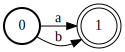

In [2]:
# For simplicity, we assume a two-character alphabet {"a", "b"}.
match = union("a", "b")
match.optimize(True)

insert

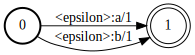

In [3]:
# We use a "1" as a non-zero weight.
insert = transducer("", match, weight=1)
insert.optimize(True)

Delete

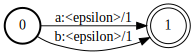

In [4]:
delete = transducer(match, "", weight=1)
# Or, equivalently: delete = invert(insert)
delete.optimize(True)

Substitude

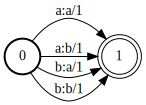

In [5]:
#the synchronize function helps to remove unnecessary epsilon arcs
substitute = synchronize(transducer(match, match, weight=1))
substitute.optimize(True)

Union of Four operations

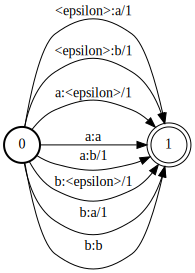

In [6]:
ops = union(match, delete, insert, substitute)
ops.optimize(True)

The ops transducer currently only accepts zero or one elements of $\Sigma$, whereas we want a transducer over the infinite set $\Sigma^{*}$. To do this, we compute its (concatenative) closure:

In [7]:
edit = ops.closure().optimize()

If you get an error "FileNotFoundError: [Errno 2] No such file or directory: 'dot': 'dot'"
Sol: Try installing sudo apt-get install graphviz in usr/lib

### Applying the Edit Transducers

To "apply" the relation expressed by the edit transducer, we first compose the input string $s_i$ with the left side of the edit transducer. The composition operation is a generalization of set intersection. When we compose an acceptor with the left size of a transducer, we are essentially intersecting the set denoted by the acceptor (here a single string) with the domain of the transducer, producing a WFST denoting a relation from $\{s_i\}$ to $\Sigma^{*}$.

We then compose the resulting transducer with the output string $s_o$. When we compose a the right size of a transducer an acceptor, we are intersecting the set denoted by the range of the transducer with the set denoted by the acceptor (here a single string). This produces a WFST denoting a relation from $\{s_i\}$ to $\{s_o\}$. We refer to this as the lattice:

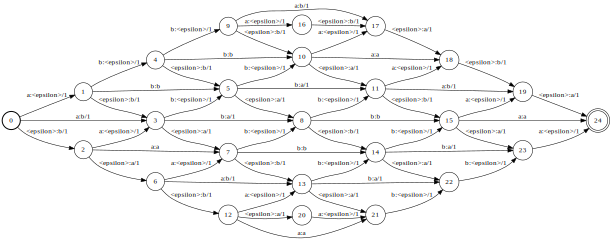

In [8]:
s_i = "abba"
s_o = "baba"
lattice = compose(compose(s_i, edit), s_o)
lattice

Every path in this lattice is a possible alignment of the string abba to the string baba, and the cost of that path is the edit distance for that alignment. when visualizing the lattice, which can be a relatively large WFST, it is sometimes helpful to first "prune" it so that it contains only the optimal paths:

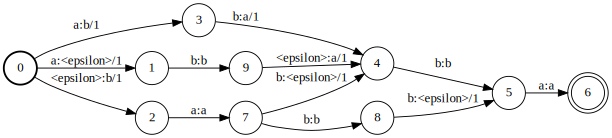

In [9]:
prune(lattice, weight = 0)


If we take the path $[0, 3, 4, 5, 6]$, along the top of the graph, we obtain the following alignment, with two matches and two substitutions:

   - abba
   - baba

If, however, we take the path $[0, 2, 7, 8, 5, 6]$, along the bottom of the graph, we obtain the following alignment, with two matches, one insertion, and one deletion:

   - _abba
   - bab_a

Both of these paths have the same cost (2) and thus are present in the pruned lattice of optimal paths. Note of course that the optimal pat ths depend on the costs we assign to the different edit operations. If, for instance, we had assigned a zero cost to insertions and a unit cost to deletions and substitution, the former path above would no longer be optimal and the latter path would have a cost of 1.